# <h1><center>Q-learning Tutorial</center></h1>

This notebook provides an introductory tutorial to Q-learning. Specifically, we will implement Q-Learning using a Q-table in JAX and use it to steer a simplified brittle star robot towards a random target. The [brittle star robot and its environment](https://github.com/Co-Evolve/brb/tree/new-framework/brb/brittle_star) is part of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb). Instead of directly outputting joint-level actions, we will use our Q-learned controller to modulate a CPG that in turn outputs the joint-level actions.


## Q-Learning

* Belongs to the class of model-free algorithms, meaning that it does not require prior knowledge (or a model) of the environment.
* Is an off-policy algorithm, meaning that it does not necessarily use the 'current policy' to produce actions
* As it name entails, the goal of the algorithm is to learn the Q-function
    * The Q-function receives state and action pairs, and (tries to) return the expected cumulative reward
        * In other words, it tries to predict the expected payoff of doing a certain action in a given state
* In this tutorial we will focus on tabular Q-learning
    * We will optimize the values of a two-dimensional table with states as rows and actions as columns.
    * Each cell in this table corresponds to the Q value of a state and action
        * As we use a table, the state and actions have to be discretized.
    * Initially, this Q-table will be populated with arbitrary values or zeros
    * The q-learning algorithm then tries to optimize the values in this table through an iterative process of exploration and exploitation.
        * During the exploration phase, the agent will take random actions to gather information about the environment and update the Q-table accordingly
        * As the agent explores more, it gradually transitions to the exploitation phase, where it leverages the learned Q-values to make more informed decisions and maximize the cumulative reward
    * The Q-learning algorithm can be summarized as follows:
        1. Initialize the Q-table with arbitrary values or zeros
        2. Observe the current state of the environment
        3. Choose an action to take based on a exploration-exploitation trade-off. This can for instance be done by using an exploration strategy like epsilon-greedy, where the agent selects a random action with a certain probability and chooses the action with the highest Q-value with a complementary probability.
        4. Perform the chosen action and observe the reward and the resulting next state
        5. Update the Q-value of the state-action pair using the Q-learning update rule:<br>
        $Q(s,a) = (1 - \alpha) Q(s,a) + \alpha(r + \gamma\max(Q(s', a')))$<br>
                where alpha $\alpha$ is the learning rate, gamma $\gamma$ is the discount factor that determines the importance of future rewards, $r$ is the immediate reward obtained (given by the environment), and $\max(Q(s', a'))$ represents the maximum Q-value for the next state. 
        6. Repeat steps $2$ to $5$ until convergence or a predefined number of iterations.
* A natural extension of the tabular Q-learning algorithm is the Deep-QLearning (DQN) algorithm. As it name gives away, the DQN algorithm swaps the Q-table for a deep Q-neural-network. This neural network maps states to Q(s, a) values. 

* This tutorial will focus on Q-Table learning 

## Implementing tabular Q-learning in JAX

When implementing something in JAX it's important to remember that JAX follows the functional programming paradigm. Put simply, we thus rely on pure functions (deterministic and without side effects) and immutable data structures (instead of changing data in place, new data structures are created with the desired modifications) as primary building blocks.

We will thus start by creating a data structure that we will use to hold our current Q-Learner's state and its related learning (hyper)parameters.

In [1]:
from typing import Tuple
import functools
import chex
from flax import struct
import jax
import jax.numpy as jnp


@struct.dataclass
class QLearningPolicyParameters:
    q_table: jnp.ndarray
    alpha: float
    epsilon: float
    gamma: float
    rng: chex.PRNGKey


class QLearningPolicy:
    def __init__(
            self,
            num_states: int,
            num_actions: int
            ) -> None:
        self._num_states = num_states
        self._num_actions = num_actions

    @functools.partial(jax.jit, static_argnums=(0,))
    def apply_q_learning_update_rule(
            self,
            policy_parameters: QLearningPolicyParameters,
            state_index: int,
            next_state_index: int,
            action_index: int,
            reward: float
            ) -> QLearningPolicyParameters:
        old_q_value = policy_parameters.q_table[state_index, action_index]
        best_future_q_value = jnp.max(policy_parameters.q_table[next_state_index])
        q_value_update = reward + policy_parameters.gamma * best_future_q_value
        new_q_value = (1 - policy_parameters.alpha) * old_q_value + policy_parameters.alpha * q_value_update

        new_q_table = policy_parameters.q_table.at[state_index, action_index].set(new_q_value)
        # noinspection PyUnresolvedReferences
        return policy_parameters.replace(q_table=new_q_table)

    @functools.partial(jax.jit, static_argnums=(0,))
    def epsilon_greedy_policy(
            self,
            policy_parameters: QLearningPolicyParameters,
            state_index: int
            ) -> Tuple[QLearningPolicyParameters, int]:
        rng, explore_rng, random_action_rng = jax.random.split(policy_parameters.rng, 3)
        explore = jax.random.uniform(explore_rng) < policy_parameters.epsilon

        def get_random_action() -> int:
            return jax.random.choice(key=random_action_rng, a=jnp.arange(policy_parameters.q_table.shape[1]))

        def get_greedy_action() -> int:
            return jnp.argmax(policy_parameters.q_table[state_index])

        action_index = jax.lax.cond(
                pred=explore, true_fun=get_random_action, false_fun=get_greedy_action
                )

        # noinspection PyUnresolvedReferences
        return policy_parameters.replace(rng=rng), action_index

    @functools.partial(jax.jit, static_argnums=(0,))
    def reset(
            self,
            rng: chex.PRNGKey,
            alpha: float,
            gamma: float,
            epsilon: float
            ) -> QLearningPolicyParameters:
        rng, q_table_rng = jax.random.split(rng, 2)
        # noinspection PyArgumentList
        return QLearningPolicyParameters(
                q_table=jax.random.uniform(
                        key=rng,
                        shape=(self._num_states, self._num_actions),
                        dtype=jnp.float32,
                        minval=-0.001,
                        maxval=0.001
                        ), alpha=alpha, epsilon=epsilon, gamma=gamma, rng=rng
                )

Great, we have implemented the tabular Q-learning algorithm. Time to test it out with the brittle star environment!

## Case study: CPG modulations for directed brittle star locomotion

### Environment setup
* Load BRB's brittle star environment -> targeted locomotion
* Create a state indexer
* Create an action mapper 

In [2]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Wed Jan 31 18:00:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A2                      On  | 00000000:3B:00.0 Off |                    0 |
|  0%   50C    P8               8W /  60W |      4MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from brb.brittle_star.environment.directed_locomotion.shared import \
    BrittleStarDirectedLocomotionEnvironmentConfiguration
import numpy as np
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from brb.brittle_star.environment.directed_locomotion.dual import BrittleStarDirectedLocomotionEnvironment
from typing import List
import mediapy as media
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena

morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=3, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=False, attach_target=True, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarDirectedLocomotionEnvironmentConfiguration(
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=10,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )


def create_environment() -> BrittleStarDirectedLocomotionEnvironment:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    env = BrittleStarDirectedLocomotionEnvironment.from_morphology_and_arena(
            morphology=morphology, arena=arena, configuration=environment_configuration, backend="MJX"
            )
    return env


def post_render(
        render_output: List[np.ndarray],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if render_output is None:
        # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
        return None

    num_cameras = len(environment_configuration.camera_ids)
    num_envs = len(render_output) // num_cameras

    if num_cameras > 1:
        # Horizontally stack frames of the same environment
        frames_per_env = np.array_split(render_output, num_envs)
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in frames_per_env]

    # Vertically stack frames of different environments
    render_output = np.concatenate(render_output, axis=0)

    return render_output[:, :, ::-1]  # RGB to BGR


def show_video(
        images: List[np.ndarray | None],
        path: str | None = None
        ) -> str | None:
    # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
    filtered_images = [image for image in images if image is not None]
    num_nones = len(images) - len(filtered_images)
    if num_nones > 0:
        logging.warning(
                f"env.render produced {num_nones} None's. Resulting video might be a bit choppy (consquence of https://github.com/google-deepmind/mujoco/issues/1379)."
                )
    if path:
        media.write_video(path=path, images=filtered_images)
    return media.show_video(images=filtered_images)

In [4]:
rng = jax.random.PRNGKey(seed=0)
env = create_environment()
env_reset_fn = jax.jit(env.reset)
env_step_fn = jax.jit(env.step)

Observation space:
Dict('in_plane_joint_position': Box(-0.5235988, 0.5235988, (15,), <class 'jax.numpy.float32'>), 'out_of_plane_joint_position': Box(-0.5235988, 0.5235988, (15,), <class 'jax.numpy.float32'>), 'in_plane_joint_velocity': Box(-inf, inf, (15,), <class 'jax.numpy.float32'>), 'out_of_plane_joint_velocity': Box(-inf, inf, (15,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (15,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'unit_xy_direction_to_target': Box(-1.0, 1.0, (2,), <class 'jax.numpy.float32'>), 'xy_distance_to_target': Box(0.0, inf, (1,), <class 'jax.numpy.float32'>))

Action space:
Box(-0.5235988, 0.5235988, (30,), <class 'jax.numpy.float32'>)


""

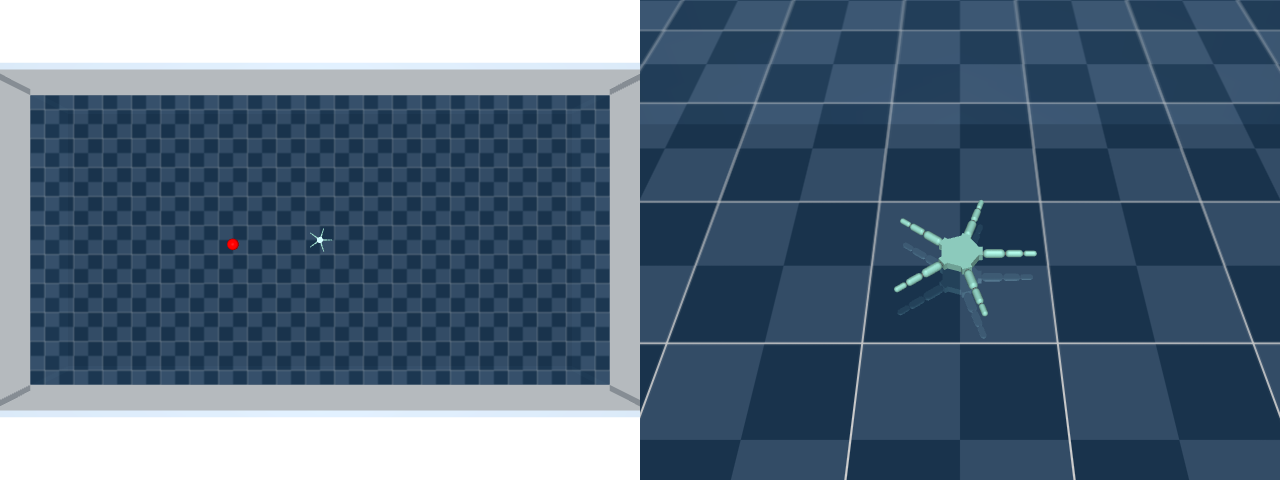

In [5]:
print("Observation space:")
print(env.observation_space)
print()
print("Action space:")
print(env.action_space)
rng, sub_rng = jax.random.split(rng, 2)
env_state = env_reset_fn(rng=sub_rng)
media.show_image(post_render(env.render(env_state), environment_configuration=env.environment_configuration))

* TODO: explain that we use the control_timestep as the CPG's dt

In [6]:
environment_configuration.control_timestep

0.04

### CPG setup

* CPG model from Sproewitz paper
* Oscillator system from the CPG tutorial

Copied CPG implementation from the CPG tutorial:

In [26]:
import functools
from flax import struct
import jax
import jax.numpy as jnp
import chex
from functools import partial
from typing import Tuple

from typing import Callable


def euler_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope = derivative_fn(current_time, y)
    next_y = y + delta_time * slope
    return next_y


def rk4_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    # This is the original euler
    slope1 = derivative_fn(current_time, y)
    # These are additional slope calculations that improve our approximation of the true slope  
    slope2 = derivative_fn(current_time + delta_time / 2, y + slope1 * delta_time / 2)
    slope3 = derivative_fn(current_time + delta_time / 2, y + slope2 * delta_time / 2)
    slope4 = derivative_fn(current_time + delta_time, y + slope3 * delta_time)
    average_slope = (slope1 + 2 * slope2 + 2 * slope3 + slope4) / 6
    next_y = y + average_slope * delta_time
    return next_y


@struct.dataclass
class CPGState:
    time: float
    phases: jnp.ndarray
    dot_amplitudes: jnp.ndarray  # first order derivative of the amplitude
    amplitudes: jnp.ndarray
    dot_offsets: jnp.ndarray  # first order derivative of the offset 
    offsets: jnp.ndarray
    outputs: jnp.ndarray

    # We'll make these modulatory parameters part of the state as they will change as well
    R: jnp.ndarray
    X: jnp.ndarray
    omegas: jnp.ndarray
    rhos: jnp.ndarray


class CPG:
    def __init__(
            self,
            weights: jnp.ndarray,
            amplitude_gain: float = 20,
            offset_gain: float = 20,
            dt: float = 0.01,
            solver: str = "euler"
            ) -> None:
        self._weights = weights
        self._amplitude_gain = amplitude_gain
        self._offset_gain = offset_gain
        self._dt = dt
        assert solver in ["euler", "rk4"], f"'solver' must be one of ['euler', 'rk4']"

        if solver == "euler":
            self._solver = euler_solver
        else:
            self._solver = rk4_solver

    @property
    def num_oscillators(
            self
            ) -> int:
        return self._weights.shape[0]

    @staticmethod
    def phase_de(
            weights: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray,
            phase_biases: jnp.ndarray,
            omegas: jnp.ndarray
            ) -> jnp.ndarray:
        @jax.vmap  # vectorizes this function for us over an additional batch dimension (in this case over all oscillators)
        def sine_term(
                phase_i: float,
                phase_biases_i: float
                ) -> jnp.ndarray:
            return jnp.sin(phases - phase_i - phase_biases_i)

        couplings = jnp.sum(weights * amplitudes * sine_term(phase_i=phases, phase_biases_i=phase_biases), axis=1)
        return omegas + couplings

    @staticmethod
    def second_order_de(
            gain: jnp.ndarray,
            modulator: jnp.ndarray,
            values: jnp.ndarray,
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:

        return gain * ((gain / 4) * (modulator - values) - dot_values)

    @staticmethod
    def first_order_de(
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:
        return dot_values

    @staticmethod
    def output(
            offsets: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray
            ) -> jnp.ndarray:
        return offsets + amplitudes * jnp.cos(phases)

    def reset(
            self,
            rng: chex.PRNGKey
            ) -> CPGState:
        phase_rng, amplitude_rng, offsets_rng = jax.random.split(rng, 3)
        # noinspection PyArgumentList
        state = CPGState(
                phases=jax.random.uniform(
                        key=phase_rng, shape=(self.num_oscillators,), dtype=jnp.float32, minval=-0.01, maxval=0.01
                        ),
                amplitudes=jnp.zeros(self.num_oscillators),
                offsets=jnp.zeros(self.num_oscillators),
                dot_amplitudes=jnp.zeros(self.num_oscillators),
                dot_offsets=jnp.zeros(self.num_oscillators),
                outputs=jnp.zeros(self.num_oscillators),
                time=0.0,
                R=jnp.zeros(self.num_oscillators),
                X=jnp.zeros(self.num_oscillators),
                omegas=jnp.zeros(self.num_oscillators),
                rhos=jnp.zeros_like(self._weights)
                )
        return state

    @functools.partial(jax.jit, static_argnums=(0,))
    def step(
            self,
            state: CPGState
            ) -> CPGState:
        # Update phase
        new_phases = self._solver(
                current_time=state.time,
                y=state.phases,
                derivative_fn=lambda
                    t,
                    y: self.phase_de(
                        omegas=state.omegas,
                        amplitudes=state.amplitudes,
                        phases=y,
                        phase_biases=state.rhos,
                        weights=self._weights
                        ),
                delta_time=self._dt
                )
        new_dot_amplitudes = self._solver(
                current_time=state.time,
                y=state.dot_amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._amplitude_gain, modulator=state.R, values=state.amplitudes, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_amplitudes = self._solver(
                current_time=state.time,
                y=state.amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_amplitudes),
                delta_time=self._dt
                )
        new_dot_offsets = self._solver(
                current_time=state.time,
                y=state.dot_offsets,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._offset_gain, modulator=state.X, values=state.offsets, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_offsets = self._solver(
                current_time=0,
                y=state.offsets,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_offsets),
                delta_time=self._dt
                )

        new_outputs = self.output(offsets=new_offsets, amplitudes=new_amplitudes, phases=new_phases)
        # noinspection PyUnresolvedReferences
        return state.replace(
                phases=new_phases,
                dot_amplitudes=new_dot_amplitudes,
                amplitudes=new_amplitudes,
                dot_offsets=new_dot_offsets,
                offsets=new_offsets,
                outputs=new_outputs,
                time=state.time + self._dt
                )


def create_cpg() -> CPG:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    adjacency_matrix = jnp.zeros((10, 10))
    # Connect oscillators within an arm
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)
    # Connect IP oscillators of neighbouring arms
    adjacency_matrix = adjacency_matrix.at[
        ip_oscillator_indices, jnp.concatenate((ip_oscillator_indices[1:], jnp.array([ip_oscillator_indices[0]])))].set(
            1
            )
    # Connect OOP oscillators of neighbouring arms
    adjacency_matrix = adjacency_matrix.at[oop_oscillator_indices, jnp.concatenate(
            (oop_oscillator_indices[1:], jnp.array([oop_oscillator_indices[0]]))
            )].set(1)

    # Make adjacency matrix symmetric (i.e. make all connections bi-directional)
    adjacency_matrix = jnp.maximum(adjacency_matrix, adjacency_matrix.T)
    # Connect oscillators within an arm
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)

    return CPG(
            weights=5 * adjacency_matrix,
            amplitude_gain=20,
            offset_gain=20,
            dt=environment_configuration.control_timestep
            )


def get_oscillator_indices_for_arm(
        arm_index: int
        ) -> Tuple[int, int]:
    return arm_index * 2, arm_index * 2 + 1


@jax.jit
def modulate_cpg(
        cpg_state: CPGState,
        leading_arm_index: int,
        joint_limit: float
        ) -> CPGState:
    left_rower_arm_indices = [(leading_arm_index - 1) % 5, (leading_arm_index - 2) % 5]
    right_rower_arm_indices = [(leading_arm_index + 1) % 5, (leading_arm_index + 2) % 5]

    leading_arm_ip_oscillator_index, leading_arm_oop_oscillator_index = get_oscillator_indices_for_arm(
            arm_index=leading_arm_index
            )

    R = jnp.zeros_like(cpg_state.R)
    X = jnp.zeros_like(cpg_state.X)
    rhos = jnp.zeros_like(cpg_state.rhos)
    omegas = 3 * jnp.pi * jnp.ones_like(cpg_state.omegas)
    phases_bias_pairs = []

    def modulate_leading_arm(
            _X: jnp.ndarray,
            _arm_index: int
            ) -> jnp.ndarray:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        return _X.at[oop_oscillator_index].set(joint_limit)

    def modulate_left_rower(
            _R: jnp.ndarray,
            _arm_index: int
            ) -> Tuple[jnp.ndarray, List[Tuple[int, int, float]]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _R = _R.at[ip_oscillator_index].set(joint_limit)
        _R = _R.at[oop_oscillator_index].set(joint_limit)
        _phase_bias_pairs = [(ip_oscillator_index, oop_oscillator_index, jnp.pi / 2)]
        return _R, _phase_bias_pairs

    def phase_biases_first_left_rower(
            _arm_index: int
            ) -> List[Tuple[int, int, float]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _phase_bias_pairs = [(ip_oscillator_index, leading_arm_ip_oscillator_index, jnp.pi / 4),
                             (leading_arm_oop_oscillator_index, oop_oscillator_index, jnp.pi / 4)]
        return _phase_bias_pairs

    def modulate_right_rower(
            _R: jnp.ndarray,
            _arm_index: int
            ) -> Tuple[jnp.ndarray, List[Tuple[int, int, float]]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _R = _R.at[ip_oscillator_index].set(joint_limit)
        _R = _R.at[oop_oscillator_index].set(joint_limit)
        _phase_bias_pairs = [(oop_oscillator_index, ip_oscillator_index, jnp.pi / 2)]
        return _R, _phase_bias_pairs

    def phase_biases_first_right_rower(
            _arm_index: int
            ) -> List[Tuple[int, int, float]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _phase_bias_pairs = [(leading_arm_ip_oscillator_index, ip_oscillator_index, jnp.pi / 4),
                             (oop_oscillator_index, leading_arm_oop_oscillator_index, jnp.pi / 4)]
        return _phase_bias_pairs

    def phase_biases_second_rowers(
            _left_arm_index: int,
            _right_arm_index: int
            ) -> List[Tuple[int, int, float]]:
        left_ip_oscillator_index, _ = get_oscillator_indices_for_arm(arm_index=_left_arm_index)
        right_ip_oscillator_index, _ = get_oscillator_indices_for_arm(arm_index=_right_arm_index)
        _phase_bias_pairs = [(left_ip_oscillator_index, right_ip_oscillator_index, jnp.pi)]
        return _phase_bias_pairs

    X = modulate_leading_arm(_X=X, _arm_index=leading_arm_index)

    R, phb = modulate_left_rower(_R=R, _arm_index=left_rower_arm_indices[0])
    phases_bias_pairs += phb

    R, phb = modulate_left_rower(_R=R, _arm_index=left_rower_arm_indices[1])
    phases_bias_pairs += phb

    R, phb = modulate_right_rower(_R=R, _arm_index=right_rower_arm_indices[0])
    phases_bias_pairs += phb

    R, phb = modulate_right_rower(_R=R, _arm_index=right_rower_arm_indices[1])
    phases_bias_pairs += phb

    phases_bias_pairs += phase_biases_first_left_rower(_arm_index=left_rower_arm_indices[0])
    phases_bias_pairs += phase_biases_first_right_rower(_arm_index=right_rower_arm_indices[0])

    phases_bias_pairs += phase_biases_second_rowers(
            _left_arm_index=left_rower_arm_indices[1], _right_arm_index=right_rower_arm_indices[1]
            )

    for oscillator1, oscillator2, bias in phases_bias_pairs:
        rhos = rhos.at[oscillator1, oscillator2].set(bias)
        rhos = rhos.at[oscillator2, oscillator1].set(-bias)

    # noinspection PyUnresolvedReferences
    return cpg_state.replace(
            R=R, X=X, rhos=rhos, omegas=omegas
            )


@jax.jit
def map_cpg_outputs_to_actions(
        cpg_state: CPGState
        ) -> jnp.ndarray:
    num_arms = 5
    num_oscillators_per_arm = 2
    num_segments_per_arm = 3

    cpg_outputs_per_arm = cpg_state.outputs.reshape((num_arms, num_oscillators_per_arm))
    cpg_outputs_per_segment = cpg_outputs_per_arm.repeat(num_segments_per_arm, axis=0)

    actions = cpg_outputs_per_segment.flatten()
    return actions

Helper function to create our CPG system:

Implement the action mapper: in this case our `action_index` is the leading arm for our CPG modulation.

In [27]:
@functools.partial(jax.jit, static_argnums=(0,))
def cpg_action_mapper(
        cpg: CPG,
        cpg_state: CPGState,
        action_index: int,
        joint_limit: float
        ) -> Tuple[CPGState, jnp.ndarray]:
    cpg_state = modulate_cpg(cpg_state=cpg_state, leading_arm_index=action_index, joint_limit=joint_limit)
    cpg_state = cpg.step(state=cpg_state)
    actions = map_cpg_outputs_to_actions(cpg_state=cpg_state)
    return cpg_state, actions

Implement the state indexer. In this case, we will only use the `unit_xy_direction_to_target` observation. We'll convert this into an actual angle w.r.t. the robot's orientation and descretize it in 5 areas (one per arm).

In [28]:
from typing import Dict


@jax.jit
def state_indexer(
        observations: Dict[str, jnp.ndarray]
        ) -> int:
    direction_to_target = observations["unit_xy_direction_to_target"]
    angle_to_target_wrt_x_axis = jnp.arctan2(direction_to_target[1], direction_to_target[0])
    disk_rotation_wrt_x_axis = observations["disk_rotation"][-1]

    angle_to_target_wrt_first_arm = angle_to_target_wrt_x_axis - disk_rotation_wrt_x_axis

    num_arms = morphology_specification.number_of_arms
    a = jnp.pi / num_arms
    bin_edges = jnp.arange(-num_arms * a, (num_arms + 1) * a, 2 * a)
    bin_index = jnp.digitize(angle_to_target_wrt_first_arm, bin_edges, right=False) - 1
    bin_index_to_arm_index = jnp.array([3, 4, 0, 1, 2])

    return bin_index_to_arm_index[bin_index]

### Validation check
* We can write a visualize_episode function
* As the current solution is quite trivial (identitiy matrix), we can do a validation of all of the above code by using this as a qtable

In [29]:
def visualize_episode(policy_parameters: QLearningPolicyParameters, rng: chex.PRNGKey) -> None:
    env_rng, cpg_rng, = jax.random.split(rng, 2) 
    
    env_state = env_reset_fn(env_rng)
    cpg_state = cpg.reset(cpg_rng)
    
    # noinspection PyUnresolvedReferences
    # make the policy deterministic
    policy_parameters = policy_parameters.replace(epsilon=0)
    
    frames = []
    while not(env_state.terminated | env_state.truncated):
        state_index = state_indexer(env_state.observations)
        policy_parameters, action_index = q_learning_policy.epsilon_greedy_policy(
                policy_parameters=policy_parameters, state_index=state_index
                ) 
        cpg_state, actions = cpg_action_mapper(cpg=cpg, cpg_state=cpg_state, action_index=action_index, joint_limit=env.action_space.high[0] * 0.5)
        
        env_state = env_step_fn(env_state, actions)
        frame = post_render(env.render(state=env_state), environment_configuration=environment_configuration)
        frames.append(frame)
    
    show_video(images=frames)

In [30]:
q_learning_policy = QLearningPolicy(num_states=5, num_actions=5)
cpg = create_cpg()

rng, episode_rng, q_learner_rng = jax.random.split(rng, 3)
policy_parameters = q_learning_policy.reset(rng=q_learner_rng, alpha=0.01, gamma=0.90, epsilon=0)
policy_parameters = policy_parameters.replace(q_table=jnp.identity(n=5))


visualize_episode(policy_parameters=policy_parameters, rng=episode_rng)

### Rollout function

* Todo: explain that this won't take environment resets into account -> okay in this case

In [31]:
from mujoco_utils.environment.mjx_env import MJXEnvState


@jax.jit
def rollout(
        rng: chex.PRNGKey,
        policy_parameters: QLearningPolicyParameters
        ) -> Tuple[QLearningPolicyParameters, jnp.ndarray]:
    """
    Do a single episode rollout
    """
    env_rng, cpg_rng = jax.random.split(rng, 2)
    env_state = env_reset_fn(rng=env_rng)
    cpg_state = cpg.reset(rng=cpg_rng)

    def policy_step(
            _state: Tuple[MJXEnvState, QLearningPolicyParameters, CPGState],
            _
            ):
        _env_state, _policy_parameters, _cpg_state = _state
        _state_index = state_indexer(_env_state.observations)

        _next_policy_parameters, _action_index = q_learning_policy.epsilon_greedy_policy(
                policy_parameters=_policy_parameters, state_index=_state_index
                )
        _next_cpg_state, _actions = cpg_action_mapper(
                cpg=cpg, cpg_state=_cpg_state, action_index=_action_index, joint_limit=env.action_space.high[0] * 0.5
                )
        _next_env_state = env_step_fn(state=_env_state, action=_actions)

        _next_state_index = state_indexer(_next_env_state.observations)
        carry = (_next_env_state, _next_policy_parameters, _next_cpg_state)
        return carry, {
                "state_index": _state_index, "next_state_index": _next_state_index, "action_index": _action_index,
                "reward": _next_env_state.reward}

    carry, scan_out = jax.lax.scan(
            policy_step,
            (env_state, policy_parameters, cpg_state),
            (),
            env.environment_configuration.total_num_control_steps
            )
    _, policy_parameters, _ = carry
    
    return policy_parameters, scan_out

### Train function

In [32]:
from typing import Union


def update_policy(
        policy_parameters: QLearningPolicyParameters,
        rollout_data: Dict[str, jnp.ndarray]
        ) -> QLearningPolicyParameters:
    
    def _update_step(
            _policy_parameters: QLearningPolicyParameters,
            data_sample: Dict[str, Union[int, float]]
            ):
        _updated_policy_parameters = q_learning_policy.apply_q_learning_update_rule(
                policy_parameters=_policy_parameters,
                state_index=data_sample["state_index"],
                next_state_index=data_sample["next_state_index"],
                action_index=data_sample["action_index"],
                reward=data_sample["reward"]
                )
        return _updated_policy_parameters, None

    policy_parameters, _ = jax.lax.scan(
        _update_step, policy_parameters, rollout_data
        )
    return policy_parameters

In [33]:
rng, q_learner_rng = jax.random.split(rng, 2)
q_learning_policy = QLearningPolicy(num_states=5, num_actions=5)
policy_parameters = q_learning_policy.reset(rng=q_learner_rng, alpha=0.01, gamma=0.9, epsilon=0.3)
cpg = create_cpg()

In [34]:
from tqdm import tqdm

def train_policy(rng: chex.PRNGKey, policy_parameters: QLearningPolicyParameters, num_episodes: int) -> QLearningPolicyParameters:
    
    for step in tqdm(range(num_episodes), desc="Training policy"):
        rng, sub_rng = jax.random.split(rng, 2)
        policy_parameters, rollout_data = rollout(rng=sub_rng, policy_parameters=policy_parameters)
        policy_parameters = update_policy(policy_parameters=policy_parameters, rollout_data=rollout_data)
        
    return policy_parameters

First iteration might take a while (jit compilation of the rollout function)

In [35]:
rng, train_rng = jax.random.split(rng, 2)
updated_policy_parameters = train_policy(rng=train_rng, policy_parameters=policy_parameters, num_episodes=200)

Training policy: 100%|██████████| 200/200 [07:59<00:00,  2.40s/it]


In [36]:
print(updated_policy_parameters.q_table - policy_parameters.q_table)

[[0.07417226 0.06798966 0.06794773 0.06523049 0.06850348]
 [0.06577508 0.06898015 0.06655133 0.06504009 0.06748398]
 [0.0740843  0.07333364 0.08133619 0.07543644 0.07446125]
 [0.05754796 0.05595827 0.05687373 0.06630529 0.06094274]
 [0.06026581 0.06100223 0.05592164 0.06171126 0.07129989]]


In [37]:
for _ in range(5):
    rng, episode_rng = jax.random.split(rng, 2)
    visualize_episode(policy_parameters=updated_policy_parameters, rng=episode_rng)

### Exploit JAX: vectorize!

* Two approaches: train multiple agents (e.g. when testing different hyperparameters) OR train a single agent with parallel data collection
    * Single agent -> width vs depth trade-off
* Todo: compare training times

#### Single agent with parallel rollouts

In [38]:
vectorized_rollout = jax.jit(jax.vmap(rollout, in_axes=(0, None), out_axes=(None, 0)))

In [39]:
rng, q_learner_rng = jax.random.split(rng, 2)
parallel_policy_parameters = q_learning_policy.reset(rng=q_learner_rng, alpha=0.01, gamma=0.9, epsilon=0.3)
cpg = create_cpg()
num_parallel_envs = 32

In [40]:
def train_single_policy_with_parallel_rollouts(rng: chex.PRNGKey, policy_parameters: QLearningPolicyParameters, num_parallel_envs: int, num_parallel_episodes: int) -> QLearningPolicyParameters:
    for step in tqdm(range(0, num_parallel_episodes * num_parallel_envs, num_parallel_envs), desc="Training policy"):
        rng, *sub_rngs = jax.random.split(rng, num_parallel_envs + 1)
        policy_parameters, rollout_data = vectorized_rollout(jnp.array(sub_rngs), policy_parameters)
        rollout_data = jax.tree_util.tree_map(lambda v: v.reshape(-1), rollout_data)
        policy_parameters = update_policy(policy_parameters=policy_parameters, rollout_data=rollout_data)
    return policy_parameters

In [ ]:
rng, train_rng = jax.random.split(rng, 2)
trained_parallel_policy_parameters = train_single_policy_with_parallel_rollouts(rng=rng, policy_parameters=parallel_policy_parameters, num_parallel_envs=num_parallel_envs, num_parallel_episodes=100)

Training policy:  25%|██▌       | 25/100 [02:18<06:55,  5.54s/it]

In [ ]:
print(trained_parallel_policy_parameters.q_table)

In [ ]:
for _ in range(5):
    rng, episode_rng = jax.random.split(rng, 2)
    visualize_episode(policy_parameters=trained_parallel_policy_parameters, rng=episode_rng)

### Conclusion

* todo: Recap what we did
* todo: describe the problems with this controller (although it is adaptive to the target location, its non-adaptive w.r.t. touch) (the modulation parameters are manually defined, but not optimal / realstic) (this is a centralized controller, we want a decentralized one (e.g. to handle loss of arms))
* todo: say that the later goal is to modulate the cpg on a lower level, i.e. the actual amplitudes, offsets, frequencies and phase biases (these will be our actions). Possibly we can remove the connections between oscillators and trust the high level controller to synchronize them / or we can use a single parameter for multiple phase biases

## Exercise
* Reduce the epsilon over time
* Modify the control loop such that we only modulate the CPG every X control steps (i.e. lower modulation frequency)
* Make the controller decentralized
    * You'll need to make the states and actions arm specific
    * E.g. like this:
        * Actions = [leading arm, left rower, right rower]
                * Or: [amplitude 0, amplitude 0.5, amplitude 1]
        * State = [arm is closest to target, arm is on left axis, arm is on right axis]
        * You'll have to modify the CPG as well!
* Experience replay (keep data buffer)